Load data

In [2]:
import pandas as pd

ratings = pd.read_csv("ml-100k/u.data",
    sep="\t",
    usecols=[0, 1, 2],
    names=['user_id', 'movie_id', 'rating'])

ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Get `users_count`, `movies_count`

In [3]:
users_count = ratings['user_id'].nunique()
movies_count = ratings['movie_id'].nunique()

users_count, movies_count

(943, 1682)

Split training from testing data

In [4]:
train_ratio = 0.8

train_ratings = ratings.sample(frac=train_ratio)
test_ratings = ratings.drop(train_ratings.index).sample(frac=1.0)

Create `ratings_matrix`.  
`ratings_matrix[i][j]` = `i`-th user's rating for `j`-th movie.

In [5]:
import numpy as np


# movies and users indexed from 1
ratings_matrix = np.zeros((users_count+1, movies_count+1), dtype=float)

def insert_rating_into_matrix(ratings_row):
    user_id = ratings_row[1]
    movie_id = ratings_row[2]
    rating = ratings_row[3]

    ratings_matrix[user_id][movie_id] = rating


for ratings_row in train_ratings.itertuples():
    insert_rating_into_matrix(ratings_row)

Create `sorted_neighbors`.  
`sorted_neighbors[i][j]` = `i`-th user's `j`-th neighbour by cosine distance.

In [41]:
from scipy import spatial

def get_distances(user1_ratings, ratings_matrix):
    return spatial.distance.cdist(user1_ratings, ratings_matrix, 
        metric='cosine')


def get_sorted_neighbors_for_user(ratings_matrix, user_id):
    distances = get_distances(ratings_matrix[user_id].reshape((1,-1)), 
        ratings_matrix[1:]).reshape(-1)

    indexes = np.arange(1, users_count+1)

    indexed_distances = np.stack((indexes, distances), axis=1)

    sorted_distances = indexed_distances[indexed_distances[:, 1].argsort()]

    # remove distance from user to himself
    sorted_distances =  np.delete(sorted_distances, 0, axis=0)

    sorted_indexes = np.delete(sorted_distances, 1, axis=1).reshape(-1).astype(int)

    return sorted_indexes


def get_sorted_neighbors_for_users(ratings_matrix):
    neighbors = np.zeros((users_count+1, users_count-1), dtype=int)

    for user_id in range (1, users_count+1):
        neighbors[user_id, :] = get_sorted_neighbors_for_user(ratings_matrix, user_id)

    return neighbors


sorted_neighbors = get_sorted_neighbors_for_users(ratings_matrix)

sorted_neighbors


array([[  0,   0,   0, ...,   0,   0,   0],
       [864, 916, 738, ..., 811, 688, 547],
       [701, 460, 104, ..., 516, 366, 135],
       ...,
       [ 32, 582, 742, ..., 235, 519, 553],
       [ 91, 263, 313, ..., 662, 369, 242],
       [301, 682, 551, ..., 258, 845, 170]])

Predict rating based on knn

In [52]:
def predict_rating(ratings_matrix, sorted_neighbors, k, user_id, movie_id):
    k_nearest_neighbors = sorted_neighbors[user_id, :k]

    movie_ratings = ratings_matrix[k_nearest_neighbors, movie_id]
    non_zero_movie_ratings = movie_ratings[movie_ratings > 0]

    if len(non_zero_movie_ratings) == 0:  
        return None
    else:
        return round(np.average(non_zero_movie_ratings))

predict_rating(ratings_matrix, sorted_neighbors, 10000, 2, 2)

3

Calculate and plot RMSE scores for different k values.

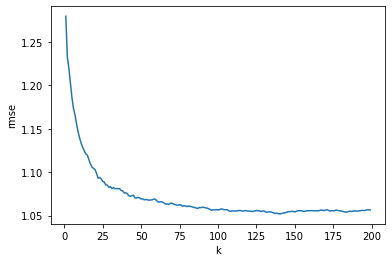

In [59]:
import math


def calculate_RMSE_for_k(ratings_matrix, sorted_neighbors, k, test_ratings):
    sum_of_roots = 0
    n = 0

    for test_rating in test_ratings.itertuples():
        predicted_rating = predict_rating(ratings_matrix,
                sorted_neighbors, k, test_rating[1], test_rating[2])
        expected_rating = test_rating[3]

        if predicted_rating is not None:
            difference = expected_rating - predicted_rating
            sum_of_roots += difference * difference
            n += 1

    return math.sqrt(sum_of_roots / n)


import matplotlib.pyplot as plt

xs = range(1, 200)
ys = [calculate_RMSE_for_k(ratings_matrix, sorted_neighbors,
    x, test_ratings) for x in xs]

plt.plot(xs, ys)
plt.xlabel('k')
plt.ylabel('rmse')
plt.show()

In [60]:
optimal_k = xs[ys.index(min(ys))]

optimal_k

140